Using pdf from Matt:
```
@article{Alberty1998Jun,
	author = {Alberty, Jochen and Carstensen, Carsten and Funken, Stefan A.},
	title = {{Remarks Around 50 Lines Of Matlab: Short Finite Element Implementation}},
	journal = {Numerical Algorithms},
	volume = {20},
	number = {2-3},
	year = {1998},
	month = {Jun},
	issn = {1017-1398},
	doi = {10.1023/A:1019155918070}
}
```

And tutorial <https://www.particleincell.com/2012/matlab-fem/>

And intro to finite elements <http://arturo.imati.cnr.it/~marini/didattica/Metodi-engl/Intro2FEM.pdf>

In [1]:
from mesh import Mesh
import numpy as np
import triangle as tr
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Test: Mesh Generation

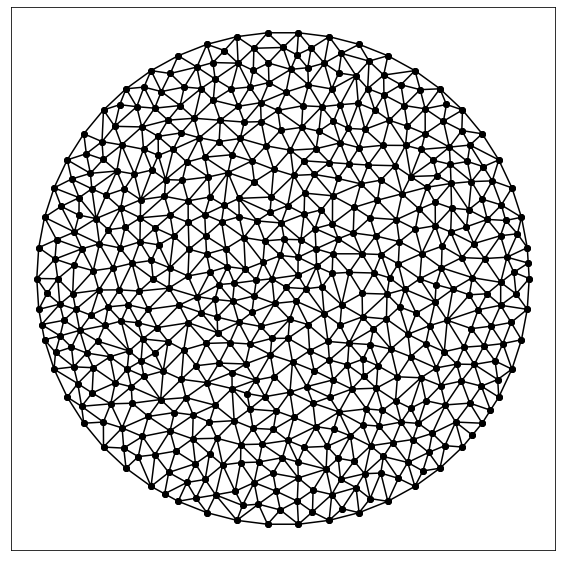

In [2]:
# Create mesh
mesh = Mesh(50, min_size=0.005, min_angle=22)

# Plot mesh
fig, axis = plt.subplots(figsize=(10,10))
tr.plot(axis, **(mesh.triangulation))
plt.show()

# Solving the Poisson Equation

- PDE: $-\nabla^2 u = f(x,y)$
- Body force: $f(x,y) = 4$
- Dirichlet boundary: $u_{boundary} = 0$.
- Analytical solution: $u(x,y) = 1 - (x^2 + y^2)$

Error is 0.036660022415776775


Text(0.5, 1.0, 'Solution')

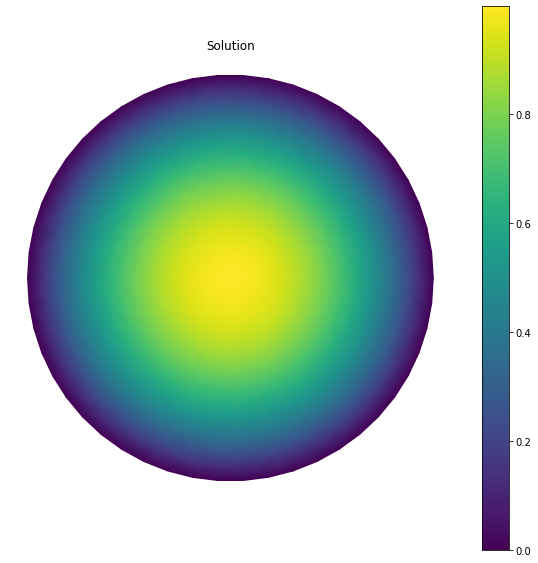

In [3]:
def calculate_body_force(vertex):
    # Body force is simply f=4
    return 4.0

def analytical_solution(vertex):
    return 1.0 - vertex[0]**2 - vertex[1]**2

stiffness = mesh.assemble_stiffness()
force_vector = mesh.assemble_body_force(calculate_body_force)

# Apply boundary conditions
stiffness[mesh.boundary_vertices,:] = 0.0
stiffness[:,mesh.boundary_vertices] = 0.0
for vertex in mesh.boundary_vertices:
    stiffness[vertex, vertex] = 1.0
force_vector[mesh.boundary_vertices] = 0.0

# Solve
rhs_vector = force_vector
soln = np.linalg.solve(stiffness, rhs_vector)

# Calculate error
error = [
    abs(soln[i] - analytical_solution(vertex))
    for i, vertex in enumerate(mesh.vertices())]

print("Error is", np.linalg.norm(error))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))
mesh.plot(soln, ax)
ax.set_title('Solution')

# Solving the Laplace Equation (Dirichlet)

- PDE: $\nabla^2 u = 0$
- Dirichlet boundary: $u(\theta) = \sin(3\theta)$
- Analytical solution: $u(r,\theta) = r^3 \sin(3\theta)$

Error is 0.03551294341532572


Text(0.5, 1.0, 'Solution')

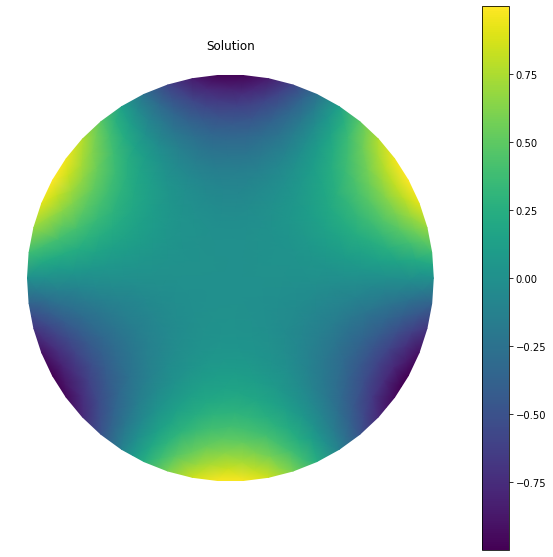

In [4]:
def theta_from_vertex(p):
    return np.arctan2(p[1], p[0])

def calculate_dirichlet_value(vertex):
    return math.sin(3*theta_from_vertex(vertex))

def analytical_solution(x, y):
    r = math.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r**3 * math.sin(3*theta)

stiffness = mesh.assemble_stiffness()

# Apply boundary conditions
# Remove boundary points from stiffness
stiffness[mesh.boundary_vertices,:] = 0.0
# And ensure matrix isn't singular
for vertex in mesh.boundary_vertices:
    stiffness[vertex, vertex] = 1.0

# Generate RHS vector
rhs_vector = np.zeros(mesh.n_vertices)
# Insert boundary conditions i.e. known nodes
rhs_vector[mesh.boundary_vertices] = mesh.calculate_boundary_values(calculate_dirichlet_value)

# Solve
soln = np.linalg.solve(stiffness, rhs_vector)

# Calculate error
error = [
    abs(soln[i] - analytical_solution(vertex[0], vertex[1]))
    for i, vertex in enumerate(mesh.vertices())]

print("Error is", np.linalg.norm(error))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))
mesh.plot(soln, ax)
ax.set_title('Solution')

# Solving the Laplace Equation (von Neumann)

- PDE: $\nabla^2 u = 0$
- von Neumann boundary: $\partial_n u (r, \theta) = \cos(\theta)$
- Analytical solution: $u(x,y) = x$
- Pure von Neumann doesn't have a unique solution, need single Dirichlet condition to fix: $u(1, 0) = 1$

Error is 0.04761298725051597


Text(0.5, 1.0, 'Solution')

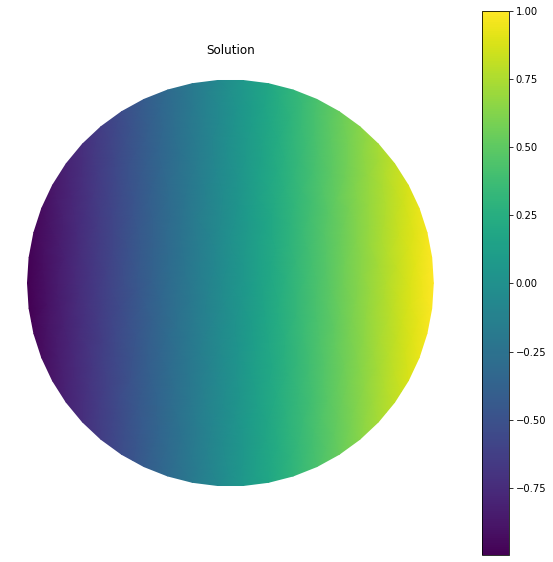

In [5]:
def theta_from_vertex(p):
    return np.arctan2(p[1], p[0])

def calculate_boundary_value(vertex):
    return math.cos(theta_from_vertex(vertex))

def generate_boundary_values(mesh):
    boundary_values = np.zeros(mesh.n_vertices)
    values = list(map(lambda index: calculate_boundary_value(mesh.get_pos(index)), mesh.boundary_vertices))
    boundary_values[mesh.boundary_vertices] = values
    return boundary_values

def analytical_solution(vertex):
    return vertex[0]

stiffness = mesh.assemble_stiffness()

# Apply dirichlet boundary conditions to stiffness
stiffness[0,:] = 0.0
for vertex in [0]:
    stiffness[vertex, vertex] = 1.0

# Assemble von neumann boundary conditions
boundary_values = generate_boundary_values(mesh)
boundary_vector = mesh.assemble_von_neumann_boundary(boundary_values)

# Generate RHS vector
rhs_vector = boundary_vector

# Apply dirichlet conditions to solution
rhs_vector[0] = 1

# Solve
soln = np.linalg.solve(stiffness, rhs_vector)

# Calculate error
error = [
    abs(soln[i] - analytical_solution(vertex))
    for i, vertex in enumerate(mesh.vertices())]

print("Error is", np.linalg.norm(error))

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10,10))
mesh.plot(soln, ax)
ax.set_title('Solution')